# Diffusion Equation in 1D

In this notebook, we compare the solution found with our time-stepping PDE solver against the known analytical solution to the diffusion equation. 

The diffusion equation in 1D is
$$
\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2},
$$
where $u(x,t)$ is the density of some material and $D$ is the diffusivity of the material.

Starting from an initial condition
$$
u(x, t_0) = \frac{1}{\sqrt{4 \pi D t_0}} \exp^{-x^2 / 4 D t_0},
$$
at time $t_0$, the diffusion equation has an analytical solution
$$
u(x, t) = \frac{1}{\sqrt{4 \pi D t}} \exp^{-x^2 / 4 D t}
$$
at a later time $t$.

In [1]:
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax_fno.solvers as solve_ivp

In [2]:
def analytical_diffusion_solution(x, t, D, L):
    """
    Analytical solution for 1D diffusion equation with:
    - Initial condition: u(x, 0) = exp(-(x-L/2)**2 / (4 * D * t0)) / j(4 * pi * D * t0) 
    - Boundary conditions: u(0, t) = u(L, t) = 0
    - Solution: u(x, t) = exp(-(x-L/2)**2 / (4 * D * t)) / (4 * pi * D * t) 
    """
    return jnp.exp(-(x - L/2)**2 / (4 * D * t)) / jnp.sqrt(4 * jnp.pi * D * t) 

In [3]:
# Set up system
L = 100.0  # domain length
nx = 1000  # number of grid points
D = 2.0  # diffusivity
bc_type = solve_ivp.BCType.DIRICHLET  # boundary condition type 
bc_values = (0.0, 0.0)  # boundary condition values
x = solve_ivp.create_uniform_grid(L, nx, bc_type)  # grid

# Resolution
dx = x[1] - x[0]
dt = 0.1

# Store PDE parameters in a dictionary
params = {
    'D': D,
    'bc_type': bc_type,
    'bc_left': bc_values[0],
    'bc_right': bc_values[1]
    }

# Load pre-defined functions for the heat equation
# Users have to write their own functions to use the solver for other equations
residual_fn = solve_ivp.heat_residual_1d

# Time parameters
t_span = (1.0, 10.0)

# Create Gaussian initial condition
u0 = analytical_diffusion_solution(x, t_span[0], D, L)

# Solve the equation
t, u = solve_ivp.solve(u0, t_span, L, residual_fn, params, jvp_fn=solve_ivp.heat_jvp_1d, dt=dt)

# Compute the analytical solution
u_analytical = [analytical_diffusion_solution(x, t[i], D, L) for i in range(len(t))]
        
# Compare at several time points
for i in range(0, len(t), len(t)//5):  # Check 5 time points
    time = t[i]
    error = jnp.linalg.norm(u[i, :] - u_analytical[i]) / jnp.linalg.norm(u_analytical[i])
    print(f"t={time:.3f}: relative error = {error:.3e}")


t=1.000: relative error = 0.000e+00
t=2.800: relative error = 7.749e-03
t=4.600: relative error = 6.038e-03
t=6.400: relative error = 4.875e-03
t=8.200: relative error = 4.113e-03
t=10.000: relative error = 3.585e-03


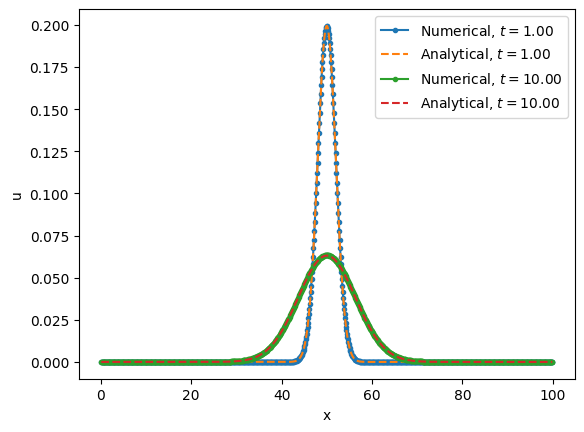

In [4]:
# Plot results
fig, ax = plt.subplots()
ax.plot(x, u[0, :], '-', marker='.', label=f"Numerical, $t={t[0]:.2f}$")
ax.plot(x, u_analytical[0], '--', label=f"Analytical, $t={t[0]:.2f}$")
ax.plot(x, u[-1, :], '-', marker='.', label=f"Numerical, $t={t[-1]:.2f}$")
ax.plot(x, u_analytical[-1], '--', label=f"Analytical, $t={t[-1]:.2f}$")
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('u')
plt.show()